In [5]:
import pandas as pd, numpy as np, shap, matplotlib.pyplot as plt, seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


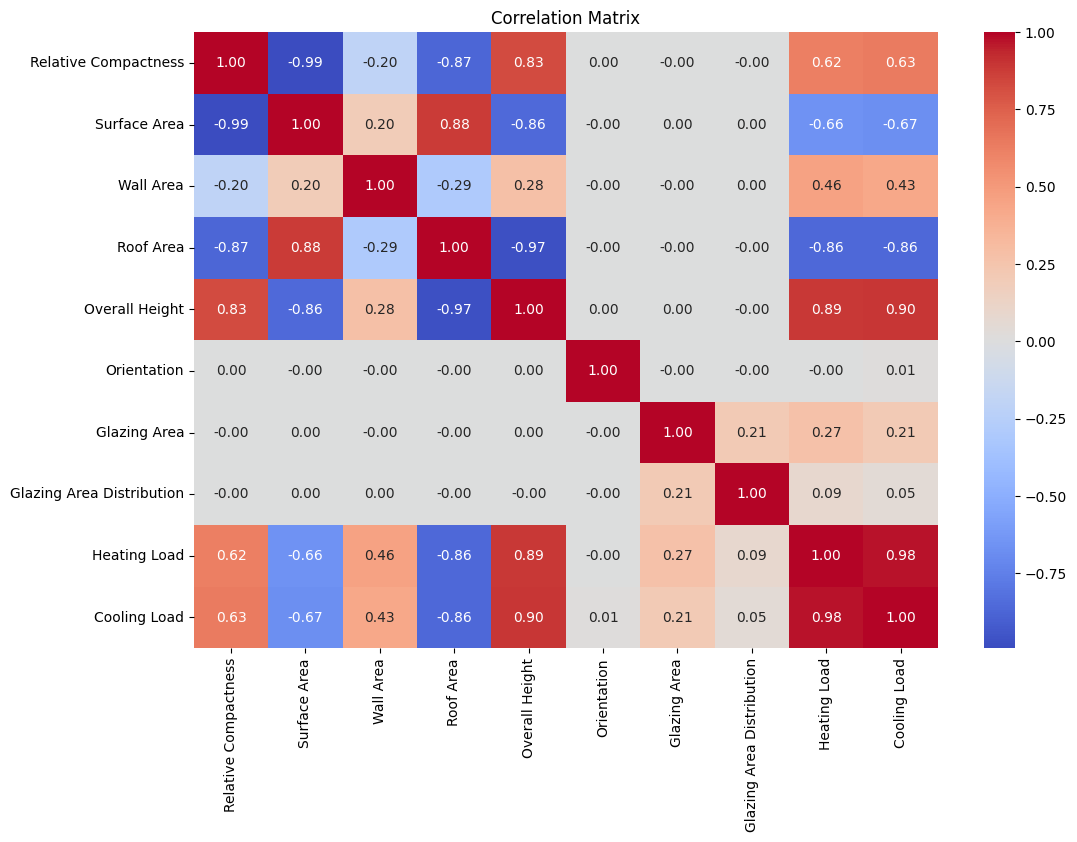

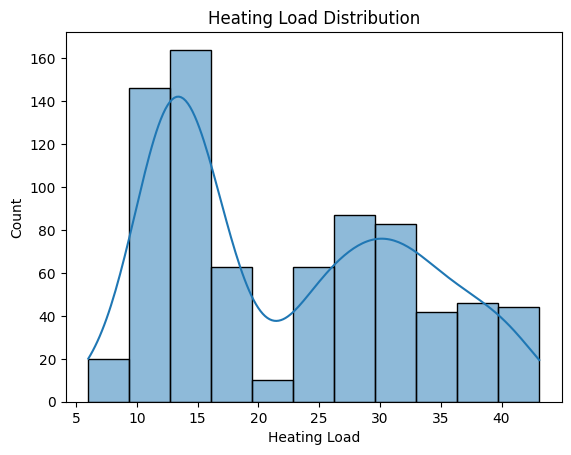

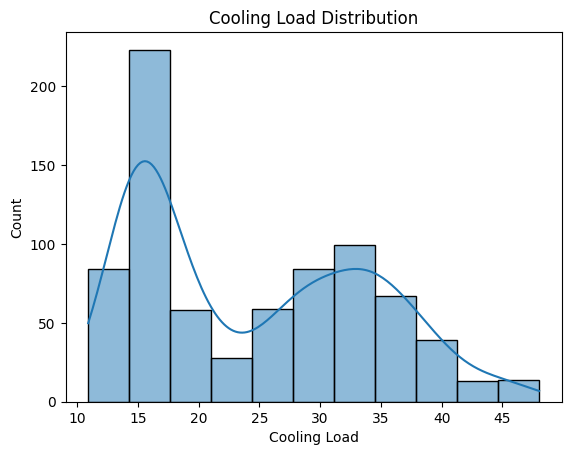

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                     feature           VIF
0                      const  3.231389e+04
1       Relative Compactness  1.055241e+02
2               Surface Area           inf
3                  Wall Area           inf
4                  Roof Area           inf
5             Overall Height  3.120547e+01
6                Orientation  1.000000e+00
7               Glazing Area  1.047508e+00
8  Glazing Area Distribution  1.047508e+00
MAE: 2.32
RMSE: 3.16
R² Score: 0.90
Random Forest MAE: 1.15
Random Forest RMSE: 2.06
Random Forest R² Score: 0.96


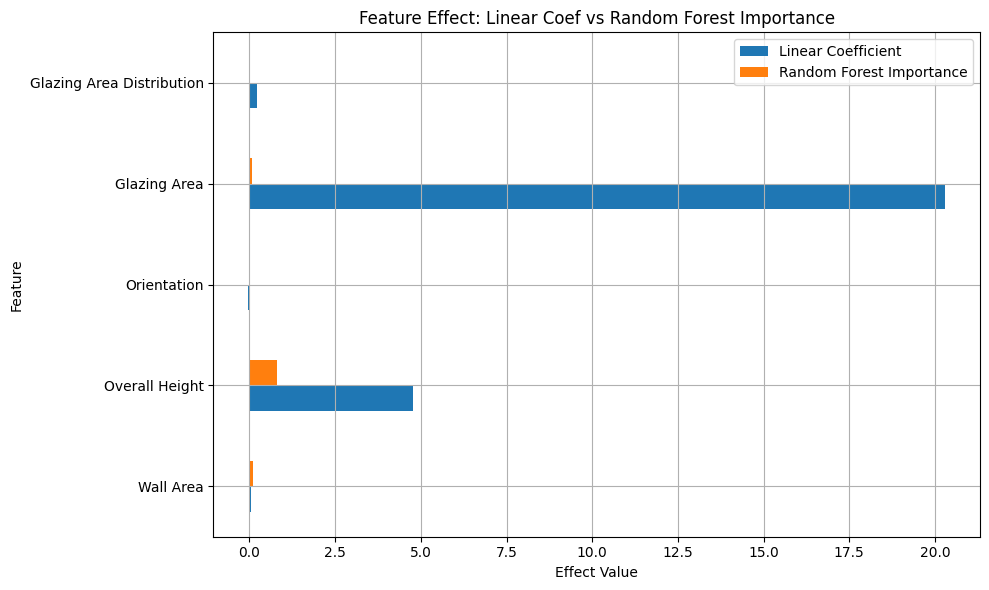

In [8]:


# 🔍 1. Loading and Preparing the Data Set


from ucimlrepo import fetch_ucirepo

# Load UCI dataset # UCI dataset with 8 architectural features and 2 target variables (Heating & Cooling Load)
data = fetch_ucirepo(id=242)
X = data.data.features
y = data.data.targets

df = pd.concat([X, y], axis=1)

# Rename columns
df.columns = [
    "Relative Compactness", "Surface Area", "Wall Area", "Roof Area",
    "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution",
    "Heating Load", "Cooling Load"
]


# 🔬 2. EDA and  Basic Statistics # Identifying distribution patterns and checking for anomalies (e.g., outliers)


# Outlier detection
def iqr_outlier_ratio(df, cols):
    total_outliers = 0
    for col in cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        total_outliers += outliers.shape[0]
    ratio = total_outliers / (len(df) * len(cols))
    return total_outliers, ratio


# 📊 3. Correlation and Distribution Analysis


plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

sns.histplot(df["Heating Load"], kde=True)
plt.title("Heating Load Distribution")
plt.show()

sns.histplot(df["Cooling Load"], kde=True)
plt.title("Cooling Load Distribution")
plt.show()


# 🔁 4. Multicollinearity Check (VIF)


X_vif = df.drop(columns=["Heating Load", "Cooling Load"])
X_vif = add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

# ⚙️ 5. Reduced Feature Set


X = df[["Wall Area", "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution"]]
y = df["Heating Load"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🔹 Linear Regression


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


## 🔹 Random Forest


rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"Random Forest R² Score: {r2_score(y_test, y_pred_rf):.2f}")

# 📉 6. Linear vs RF Comparison # Comparing feature importance from both linear and non-linear models to identify stability

linear_coefs = model.coef_
comparison = pd.DataFrame({
    "Feature": X.columns,
    "Linear Coefficient": linear_coefs,
    "Random Forest Importance": rf_model.feature_importances_
})

comparison.set_index("Feature").plot(kind="barh", figsize=(10,6))
plt.title("Feature Effect: Linear Coef vs Random Forest Importance")
plt.xlabel("Effect Value")
plt.grid(True)
plt.tight_layout()
plt.show()


# # 🧪 7. Feature Reduced Model

# ```python
# selected_features = ["Overall Height", "Wall Area", "Glazing Area"]
# ...
# print(f"Reduced RF R² Score: {r2_score(y_test_r, y_pred_rf_r):.2f}")
# ```

# # 🔍 8. SHAP Explainability Analysis

# ```python
# explainer = shap.Explainer(rf_reduced, X_train_r)
# shap_values = explainer(X_train_r)
# shap.summary_plot(shap_values, X_train_r)
# shap.plots.waterfall(shap_values[5])
# plt.show()
# ```

# # 🌐 9. Streamlit Interface # Interactive UI for users to input building parameters and get real-time heating load prediction

# ```python
# @st.cache_resource
# def train_model():
#     ...
# t.title("🏠 Heating Load Estimation Tool")
# st.markdown("Model: Random Forest | Explanation: SHAP")

# # Slider Input
# height = st.slider("Overall Height (m)", 3.5, 7.0, 3.5, 0.25)
# wall = st.slider("Wall Area (m²)", 200.0, 400.0, 300.0, 10.0)
# glazing = st.slider("Glazing Area (ratio)", 0.0, 0.4, 0.25, 0.05)

# # Prediction Result
# st.success(f"🏗️ Estimated Heating Load: **{prediction:.2f} kWh**")

# # SHAP output
# st.subheader("🎯 Prediction Explanation (SHAP)")


